In [21]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.image as mpimg

from keras.models import Sequential, load_model
from keras.datasets import cifar10
from keras.utils import np_utils,plot_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPool2D, MaxPool3D, Input
from sklearn.model_selection import train_test_split

tf.compat.v1.Session(
    config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: DML, pci bus id: <undefined>
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: DML, pci bus id: <undefined>



In [2]:
print("tensorflow version: ", tf.__version__)
print(tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

tensorflow version:  2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Num GPUs Available:  2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6438804693126649035
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16979219790
locality {
  bus_id: 1
}
incarnation: 8412626703445258183
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15318312704
locality {
  bus_id: 1
}
incarnation: 9509660760813262063
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [3]:
# os.environ['CUDA_VISIBLE_DEVICES']='-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
Y_train = np_utils.to_categorical(y_train)
print(Y_train.shape, y_train.shape)
Y_test = np_utils.to_categorical(y_test)
print(Y_test.shape, y_test.shape)

(50000, 10) (50000, 1)
(10000, 10) (10000, 1)


In [6]:
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 2000)
print(X_train_cnn.shape, Y_train_cnn.shape)

(45000, 32, 32, 3) (45000, 10)


In [7]:
activation1 = 'relu'
model = Sequential()
channel1 = 100
channel2 = 200
channel3 = 400
model.add(Conv2D(channel1, (9, 9), input_shape=(32, 32, 3), activation=activation1))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(channel1, (5, 5), activation=activation1))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(channel1, (3, 3), activation=activation1))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(channel3, activation=activation1))
model.add(Dropout(.5))
model.add(Dense(160, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       24400     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 100)         250100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 100)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 100)         90100     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 100)        0

In [8]:
start = time.time()
model.fit(X_train_cnn, Y_train_cnn, epochs = 3, batch_size = 2000, verbose = True)
print("time = ", time.time() - start)

Epoch 1/3
23/23 [==============================] - 52s 2s/step - loss: 3.5913 - accuracy: 0.1012
Epoch 2/3
23/23 [==============================] - 41s 2s/step - loss: 2.3027 - accuracy: 0.1039
Epoch 3/3
23/23 [==============================] - 41s 2s/step - loss: 2.3026 - accuracy: 0.1020
time =  137.10249257087708


In [9]:
# show_train_history('acc', 'val_acc')

In [10]:
# show_train_history('loss', 'loss_acc')

In [11]:
def get_ANN_accuracy(predicted, expected, threshold):
    a = np.array([0,1,2,3,4,5,6,7,8,9])
    expected_y = expected.dot(a)
    expected_y = expected_y.astype(int)
    Index_missed = []
    Score_at_expect = []
    Expect_missed = []
    Score_at_predict = []
    Predict_missed = []
    
    for j in range(expected_y.shape[0]):
        score_at_expect = predicted[j, expected_y[j]]
        if(score_at_expect < threshold):
            Index_missed.append(j)
            Expect_missed.append(expected_y[j])
            Score_at_expect.append(score_at_expect)
            
            max_score = max(predicted[j])
            Score_at_predict.append(max_score)
            for k in range(10):
                if(predicted[j, k] == max_score):
                    Predict_missed.append(k)
                    break
    correct_rate = 1 - len(Index_missed)/expected_y.shape[0]
    return correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict

In [12]:
def get_topN_ANN_accuracy(predicted, expected, topN, threshold):
    a = np.array([0,1,2,3,4,5,6,7,8,9])
    
    expected_y = expected.dot(a)
    expected_y = expected_y.astype(int)
    
    Index_missed = []
    Score_at_expect = []
    Expect_missed = []
    Score_at_predict = []
    Predict_missed = []
    
    for k in range(expected_y.shape[0]):
        score_at_expect = predicted[k, expected_y[k]]
        
        tmp_pred = predicted[k]
        tmp_y = expected_y[k]
        tmp_sort = sorted(tmp_pred, reverse = True)
        topN_score = sum(tmp_sort[0:topN])
        max_score = tmp_sort[0]
        topN_index = []
        for i in range(topN):
            for j in range(10):
                if(tmp_pred[j] == tmp_sort[i]):
                    topN_index.append(j)
                    break
        INtopN = any(t == tmp_y for t in topN_index)
        
        if(topN_score < threshold or not INtopN):
            Index_missed.append(k)
            Score_at_expect.append(score_at_expect)
            Expect_missed.append(expected_y[j])
            Score_at_predict.append(topN_score)
            Predict_missed.append(topN_index)
            
    correct_rate = 1 - len(Index_missed)/expected_y.shape[0]
    return correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict

In [13]:
pred_test = model.predict(X_test_cnn)
pred_train = model.predict(X_train_cnn)

1407/1407 [==============================] - 39s 28ms/step


In [14]:
threshold = 0.3

correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict\
= get_ANN_accuracy(pred_test, Y_test_cnn, threshold)
print(correct_rate)

threshold = 0.3
topN = 3

correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict\
=get_topN_ANN_accuracy(pred_test, Y_test_cnn, topN, threshold)
print(correct_rate)

0.0
0.30179999999999996


In [15]:
threshold = 0.5

correct_rate, expected_y, index_missed, expect_missed, predict_missed, score_at_expect, score_at_predict\
=get_ANN_accuracy(pred_test, Y_test_cnn, threshold)
print(correct_rate)

correct_rate, expected_y, index_missed, expect_missed, predict_missed, score_at_expect, score_at_predict\
=get_topN_ANN_accuracy(pred_train, Y_train_cnn, topN, threshold)
print(correct_rate)

0.0
0.0


# 7. create more training images from the original training images

* create more training images by flip, updown, leftright

* The final training image size is 4x of the original

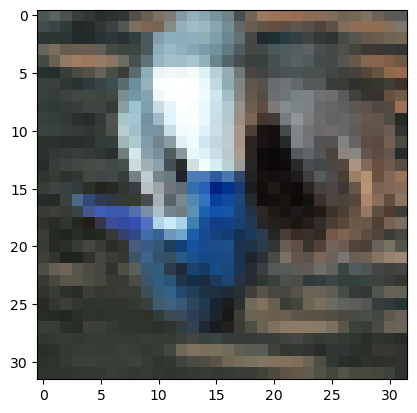

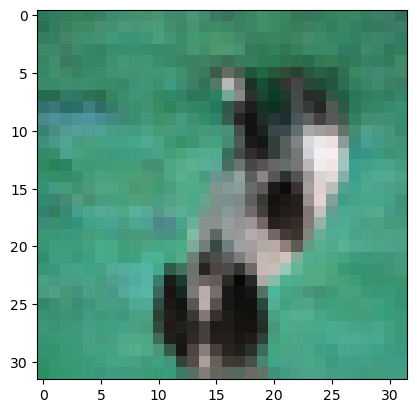

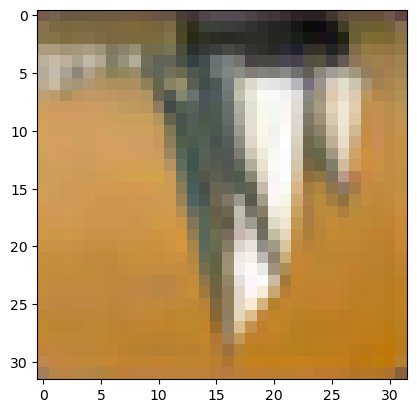

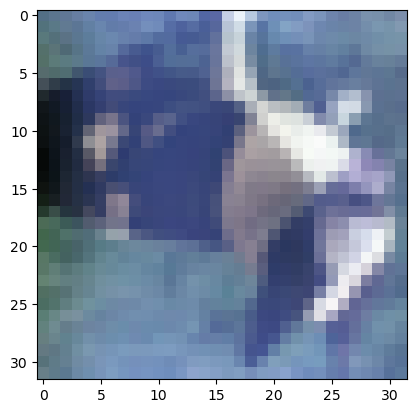

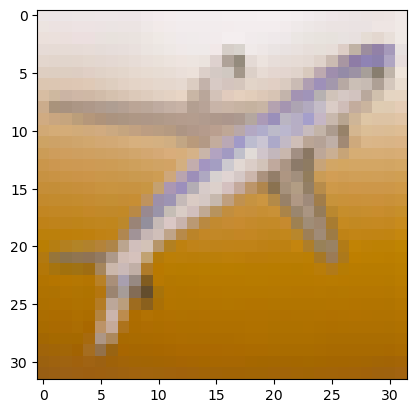

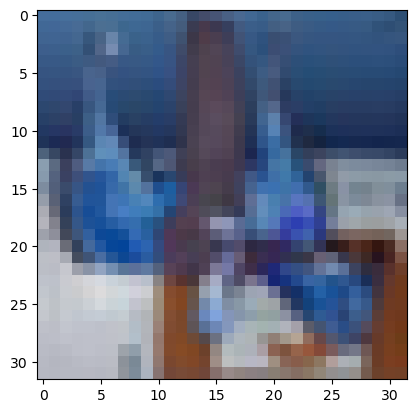

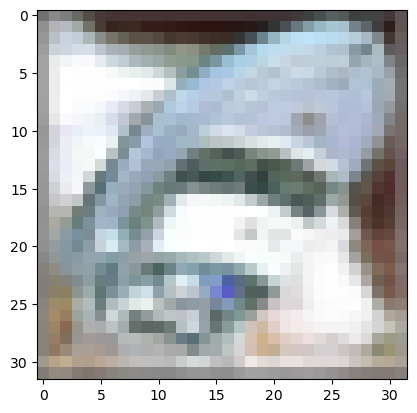

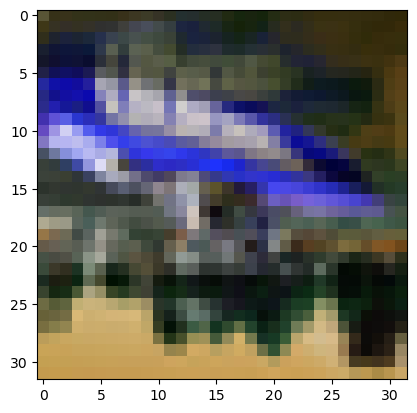

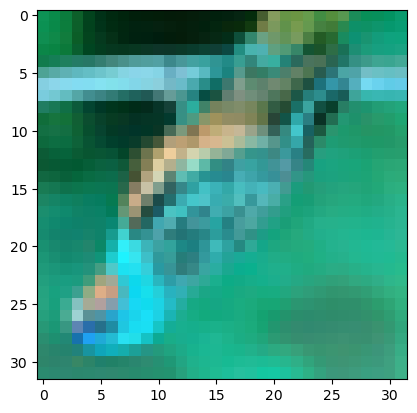

In [16]:
for i in X_train_cnn[:9]:
    plt.imshow(np.flip(i))
    plt.show()

In [17]:
X1 = [np.flip(i) for i in X_train_cnn]
X2 = [np.fliplr(i) for i in X_train_cnn]
X3 = [np.flipud(i) for i in X_train_cnn]
X = np.concatenate((X_train_cnn, X1, X2, X3))
Y = np.concatenate((Y_train_cnn, Y_train_cnn, Y_train_cnn, Y_train_cnn))
print(X.shape)

(180000, 32, 32, 3)


In [18]:
activation1 = 'relu'
model1 = Sequential()
channel1 = 100
channel2 = 200
channel3 = 400
model1.add(Conv2D(channel1, (9, 9), input_shape=(32, 32, 3), activation=activation1))
model1.add(MaxPool2D(pool_size=2))
model1.add(Conv2D(channel1, (5, 5), activation=activation1))
model1.add(MaxPool2D(pool_size=2))
model1.add(Conv2D(channel1, (3, 3), activation=activation1))
model1.add(MaxPool2D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(channel3, activation=activation1))
model1.add(Dropout(.5))
model1.add(Dense(160, activation = 'relu'))
model1.add(Dense(40, activation = 'relu'))
model1.add(Dense(10, activation = 'softmax'))
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 100)       24400     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 100)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 100)         250100    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 100)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 100)         90100     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 100)       

In [19]:
start = time.time()
model1.fit(X, Y, epochs = 10, batch_size = 1000, verbose = True)
print("time = ", time.time() - start)

Epoch 1/10
180/180 [==============================] - 172s 927ms/step - loss: 2.4038 - accuracy: 0.1609
Epoch 2/10
180/180 [==============================] - 167s 926ms/step - loss: 1.8709 - accuracy: 0.3191
Epoch 3/10
180/180 [==============================] - 166s 924ms/step - loss: 1.7152 - accuracy: 0.3789
Epoch 4/10
180/180 [==============================] - 167s 926ms/step - loss: 1.6411 - accuracy: 0.4093
Epoch 5/10
180/180 [==============================] - 167s 927ms/step - loss: 1.5746 - accuracy: 0.4355
Epoch 6/10
180/180 [==============================] - 166s 922ms/step - loss: 1.5225 - accuracy: 0.4574
Epoch 7/10
180/180 [==============================] - 168s 931ms/step - loss: 1.4810 - accuracy: 0.4748
Epoch 8/10
180/180 [==============================] - 166s 924ms/step - loss: 1.4490 - accuracy: 0.4857
Epoch 9/10
180/180 [==============================] - 166s 923ms/step - loss: 1.4124 - accuracy: 0.4996
Epoch 10/10
180/180 [==============================] - 168s 931m

# 8. test some personal images

## 8.1 acquire images

In [22]:
a3 = mpimg.imread('Cifar10/airplan3.jpeg')
a2 = mpimg.imread('Cifar10/airplane2.jpeg')
a4 = mpimg.imread('Cifar10/airplan4.jpeg')
d1 = mpimg.imread('Cifar10/dog1.jpeg')
d2 = mpimg.imread('Cifar10/dog2.jpeg')
d3 = mpimg.imread('Cifar10/dog3.jpeg')
d4 = mpimg.imread('Cifar10/dog4.jpeg')
c1 = mpimg.imread('Cifar10/cat1.jpeg')
c2 = mpimg.imread('Cifar10/cat2.jpeg')
c3 = mpimg.imread('Cifar10/cat3.jpeg')
c4 = mpimg.imread('Cifar10/cat4.jpeg')
t1 = mpimg.imread('Cifar10/truck1.jpeg')
t2 = mpimg.imread('Cifar10/truck2.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'Cifar10/airplan3.jpeg'

## 8.2 resize the images to be consistent with the model

In [ ]:
tmp = d1
dd1 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = d2
dd2 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = d3
dd3 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = d4
dd4 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

In [ ]:
tmp = c1
cc1 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = c2
cc2 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = c3
cc3 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

tmp = c4
cc4 = np.array(tmp[0:int(tmp.shape[0]/32)*32:int(tmp.shape[0]/32),\
                  0:int(tmp.shape[1]/32)*32:int(tmp.shape[1]/32)])

In [ ]:
personal_image_array_orig = np.array([a2,a3,a4,c1,c2,c3,c4,d1,d2,d3,d4,t1,t2])
expected = [0,0,0,1,1,1,1,5,5,5,5]
personal_image_array = np.array([aa2,aa3,aa4,cc1,cc2,cc3,cc4,dd1,dd2,dd3,dd4,tt1,tt2])
expected = [0,0,0,1,1,1,1,5,5,5,5,9,9]
Expected = np_utils.to_categorical(expected)

In [ ]:
plt.figure(figsize=(40,15))
for i in range(len(personal_image_array)):
    ax = plt.subplot(3,5,i+1)
    plt.imshow(personal_image_array_orig[i])
plt.show()

plt.figure(figsize=(40,15))
for i in range(len(personal_image_array)):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(personal_image_array[i])
plt.show()

## 8.3 Test with the model with original 45000 training images plus flip, updown and leftright . Total training images is 180000.

In [ ]:
Expected = np_utils.to_categorical(expected)
personal_image_array = np.array([aa2,aa3,aa4,cc1,cc2,cc3,cc4,dd1,dd2,dd3,dd4,tt1,tt2])
pred = model1.predict(personal_image_array)

In [ ]:
threshold = 0.5

correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict\
=get_ANN_accuracy(pred, Expected, threshold)
# print(correct_rate)

In [ ]:
print(Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict)

In [ ]:
print(class_name)

In [ ]:
plt.figure(figsize=(30,8))
j = 0
for i in Index_missed:
    ax = plt.subplot(1, 5, j+1)
    plt.imshow(personal_image_array[i])
    
    plt.title(class_name[Expect_missed[j]] + " " + str(int(Score_at_expect[j]*100)), fontsize = 20)
    plt.xlabel(class_name[Predict_missed[j]] + " " + str(int(Score_at_predict[j]*100)), fontsize = 20)
    
    j = j+1
plt.show()

## 8.4 Test with the model with original 45000 training images

In [ ]:
Expected = np_utils.to_categorical(expected)
personal_image_array = np.array([aa2,aa3,aa4,cc1,cc2,cc3,cc4,dd1,dd2,dd3,dd4,tt1,tt2])
pred = model1.predict(personal_image_array)

threshold = 0.5

correct_rate, expected_y, Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict\
=get_ANN_accuracy(pred, Expected, threshold)
print(Index_missed, Expect_missed, Predict_missed, Score_at_expect, Score_at_predict)

In [ ]:
plt.figure(figsize=(30,8))
j = 0
for i in Index_missed:
    ax = plt.subplot(1, 5, j+1)
    plt.imshow(personal_image_array[i])
    
    plt.title(class_name[Expect_missed[j]] + " " + str(int(Score_at_expect[j]*100)), fontsize = 20)
    plt.xlabel(class_name[Predict_missed[j]] + " " + str(int(Score_at_predict[j]*100)), fontsize = 20)
    
    j = j+1
plt.show()